In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from BorutaShap import BorutaShap
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
food_data = pd.read_csv('../data/processed_data/diet.csv')
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Miscellaneous,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables
0,0.000030,0.209212,0.094048,0.0,0.932183,0.102107,0.000030,0.172718,0.099611,0.307722,0.020510,0.164290,0.014672,0.073098,0.086036,0.004887,0.161764,0.0,0.093136,0.087701,0.839472,0.118219,0.259702
1,0.140102,0.706896,0.102562,0.0,0.190717,0.462279,0.028297,0.341492,0.288519,0.917774,0.040196,0.278848,0.074529,0.085016,0.000402,0.053821,0.100273,0.0,0.148501,0.207074,0.278154,0.128436,0.611097
2,0.019552,0.275546,0.016821,0.0,0.539036,0.311591,0.027459,0.298529,0.104371,0.412494,0.067004,0.079743,0.024465,0.140397,0.092487,0.111608,0.139696,0.0,0.176586,0.151658,0.743623,0.397735,0.595502
3,0.404646,0.206405,0.034244,0.0,0.330536,0.025393,0.228756,0.266748,0.264876,0.043159,0.043857,0.165409,0.133725,0.202901,0.000453,0.582692,0.030827,0.0,0.137324,0.004308,0.753912,0.232472,0.105695
4,0.263935,0.725172,0.111637,0.0,0.120333,0.125973,0.437713,0.402774,0.689613,0.403340,0.227956,0.210045,0.055471,0.053701,0.233798,0.029236,0.173150,0.0,0.318216,0.043437,0.208668,0.372299,0.271631


In [ ]:
control = pd.read_csv('../data/raw_data/control/regression_targets.csv')
targets = control[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)

In [ ]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_food = food_data.columns.drop(label_values)
features_food = features_food.drop(['Country'])
X_food = food_data[features_food]
Y_food = food_data[label_values]

In [ ]:
selected_features_food = pd.read_csv('../data/feature_selection/selected_features_rfe_shap_food.csv')
selected_features_food = selected_features_food['selected_features']

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=LeaveOneOut())
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_absolute_error').mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_median_absolute_error').mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='neg_mean_squared_error').mean()
  scores['r2'] = cross_val_score(regressor, data, target, cv=n_folds, scoring='r2').mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut())
  return scores, predictions

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [ ]:
food_params, food_score = hyper_parameter_search(X_food[selected_features_food], Y_food['Deaths'], PARAMS)

[19:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {food_params}')
print(f'score: {food_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 50}
score: -0.02369744916340026


In [ ]:
xgb_food = XGBRegressor(gamma = food_params['gamma'],
                        learning_rate = food_params['learning_rate'],
                        max_depth = food_params['max_depth'], 
                        min_child_weight = food_params['min_child_weight'],
                        n_estimators = food_params['n_estimators'],
                        random_state=0)

In [ ]:
scores_food, predictions_food = cross_validation_predictions(xgb_food, X_food[selected_features_food],
                                                             Y_food['Deaths'])

[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
scores_food

{'neg_mean_absolute_error': -0.02647629072930538,
 'neg_mean_squared_error': -0.001406741272032793,
 'neg_median_absolute_error': -0.016984250465897983,
 'r2': 0.3735747965296538}

In [ ]:
abs_difs_food = np.abs(predictions_food - Y_food['Deaths'].values)

In [ ]:
ordered_values = []
for i in range(len(abs_difs_food)):
  node = {}
  node['predicted'] = predictions_food[i]
  node['actual'] = Y_food['Deaths'].values[i]
  node['error'] = abs_difs_food[i]
  node['country'] = food_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

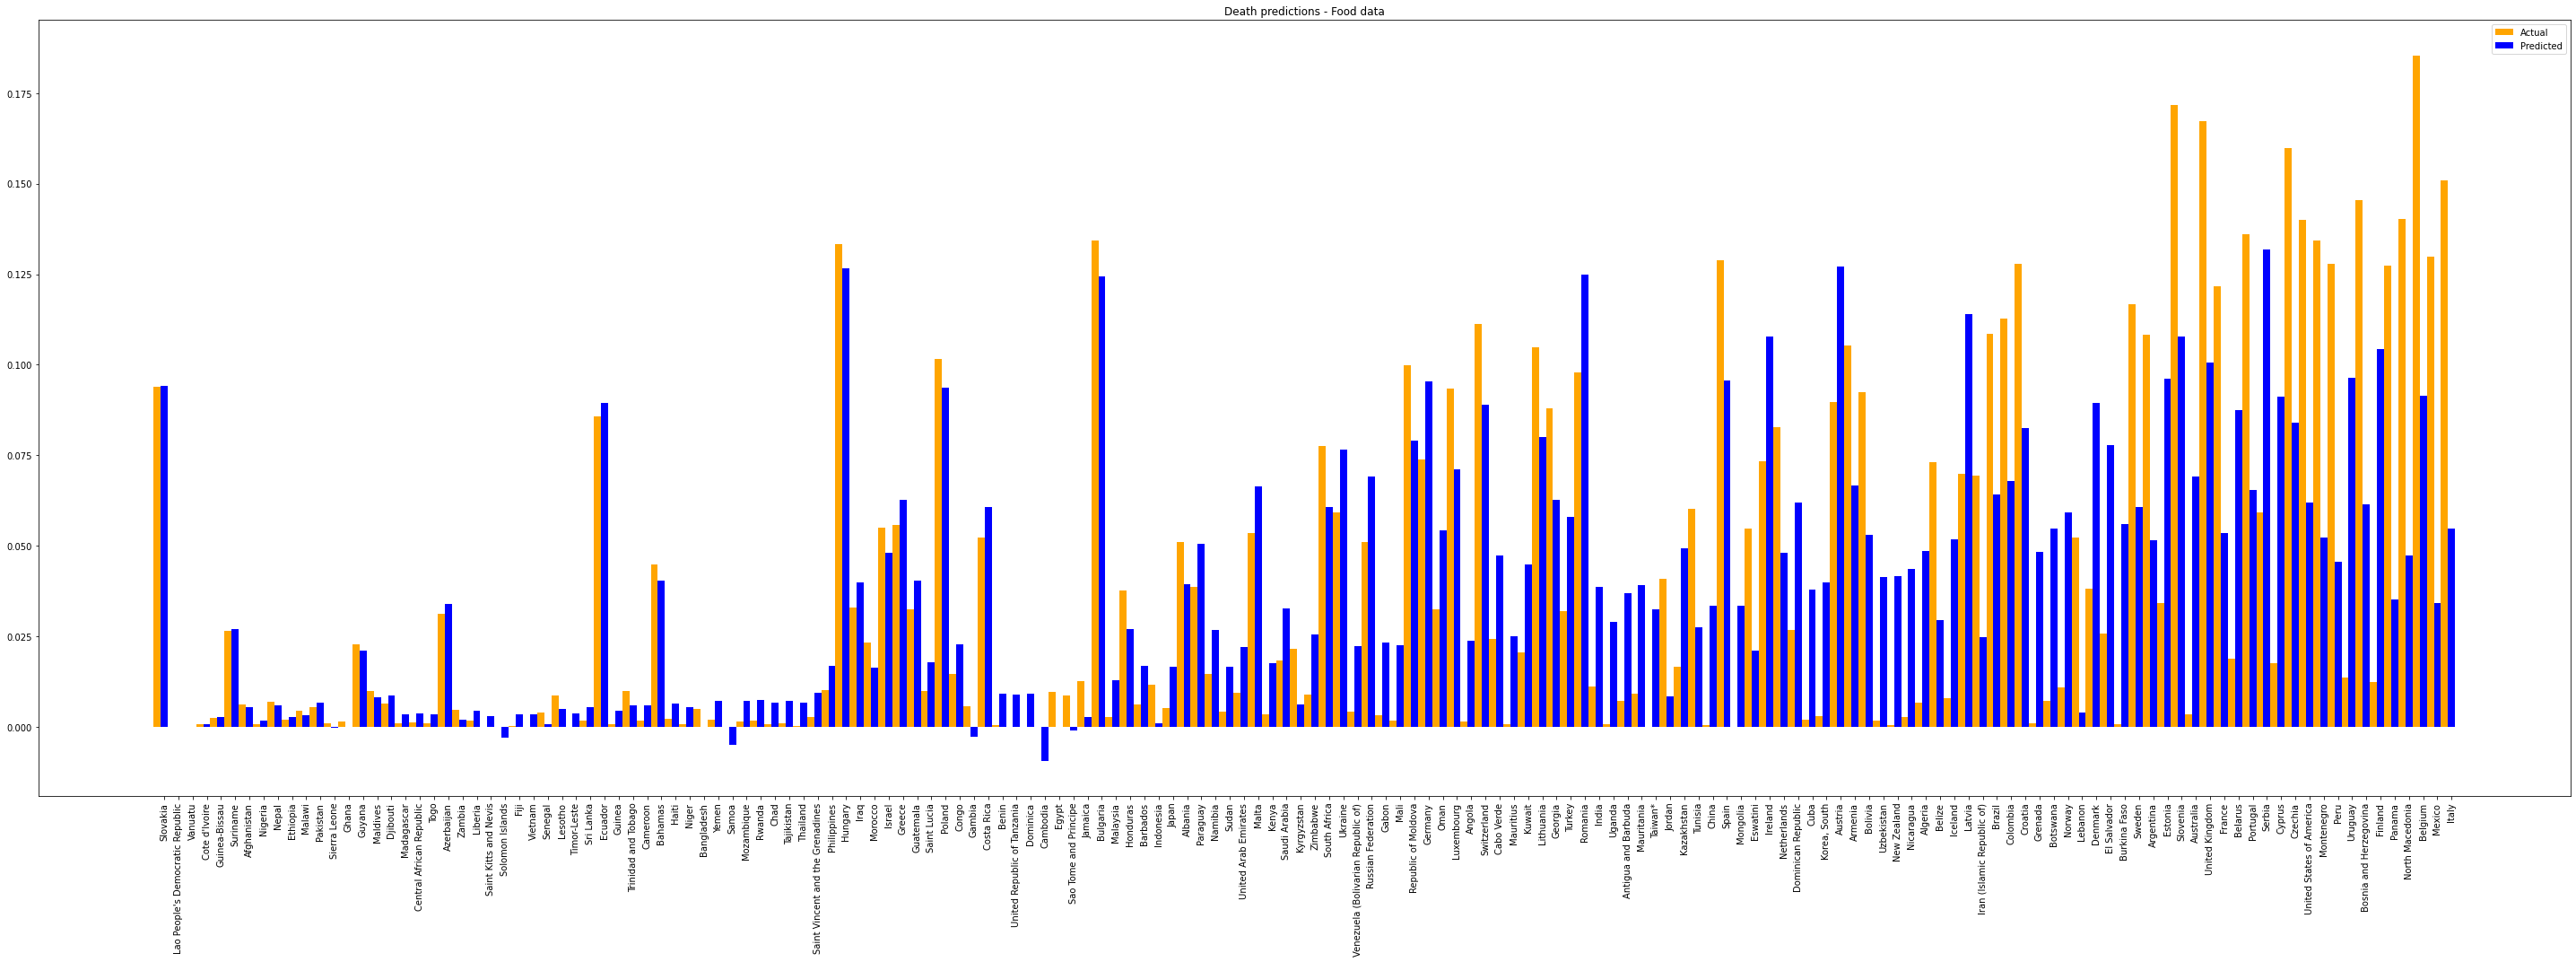

In [ ]:
x = np.arange(1, len(X_food) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.legend(['Actual', 'Predicted'])
plt.title('Death predictions - Food data')
plt.tight_layout()

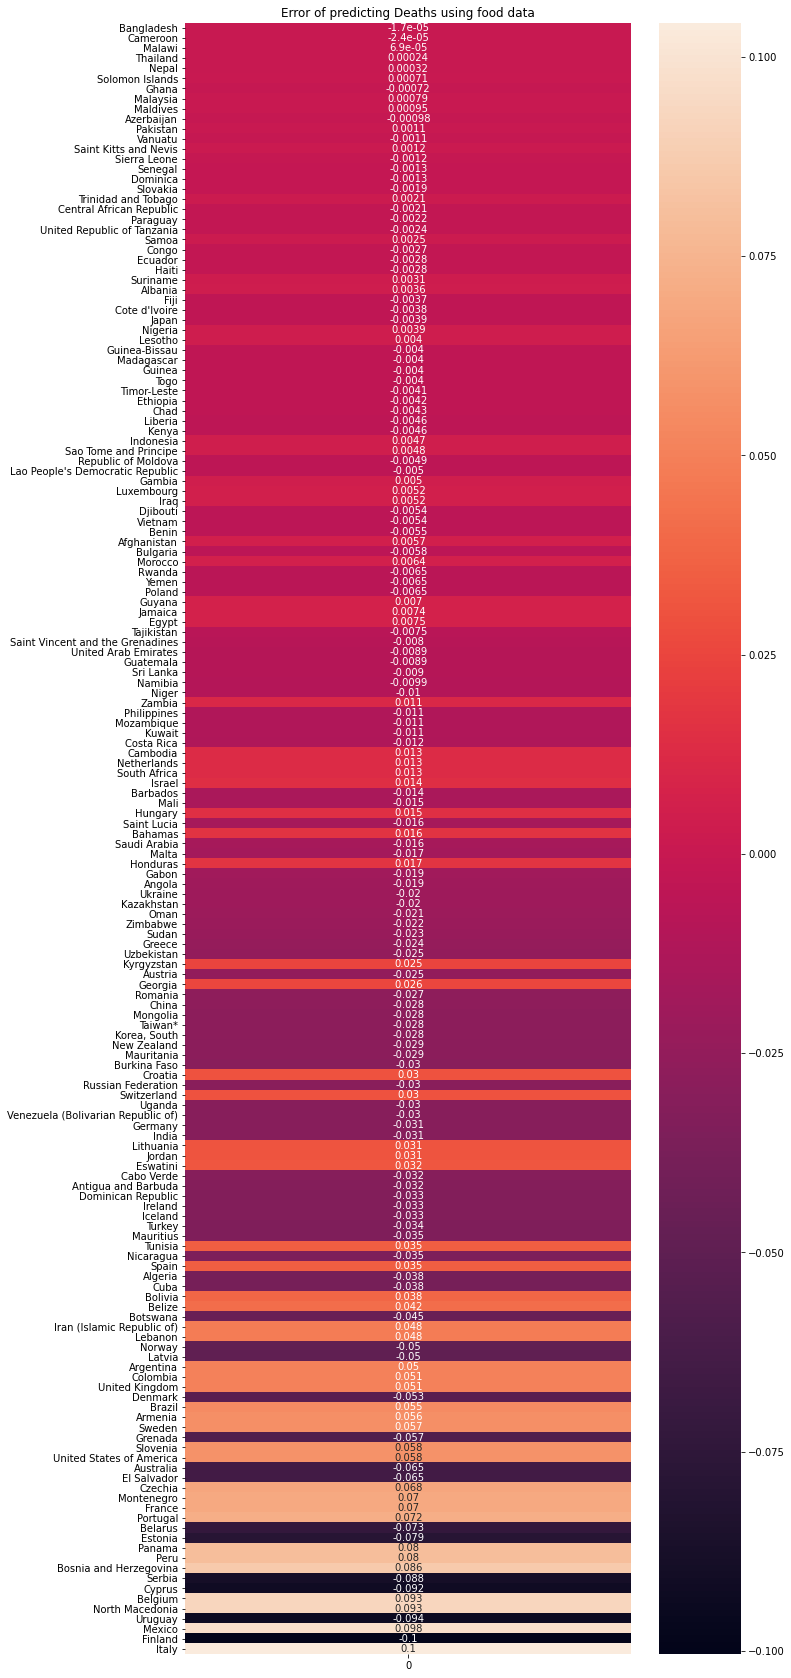

In [ ]:
errors_food = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_food = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_food, annot=True, yticklabels=countries_food)
plt.title("Error of predicting Deaths using food data")